C:\Users\Jan\AppData\Local\Temp\ipykernel_30560\4163546956.py:70: RuntimeWarning: Mean of empty slice
  ssep_mean = np.nanmean(valid_ssep)


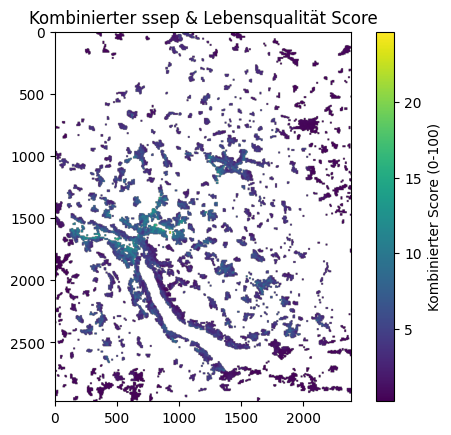

In [4]:
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

ssep_path = "../geoserver_data/data/ssep.tif"
quality_path = "../geoserver_data/data/zurich_fuzzy_quality.tif"

with rasterio.open(ssep_path) as src:
    ssep = src.read(1).astype(float)
    ssep_nodata = src.nodata
    ssep = np.where(ssep == ssep_nodata, np.nan, ssep)
    ssep_transform = src.transform
    ssep_crs = src.crs

with rasterio.open(quality_path) as src:
    quality = src.read(1).astype(float)
    quality_nodata = src.nodata
    quality_mask = np.where(quality == quality_nodata, 0, 1)
    quality_data = np.where(quality == quality_nodata, 0, quality)
    quality_transform = src.transform
    quality_crs = src.crs
    profile = src.profile

# --- Reproject ssep on Zürich-Grid ---
ssep_resampled = np.empty_like(quality_data, dtype=float)
reproject(
    source=ssep,
    destination=ssep_resampled,
    src_transform=ssep_transform,
    src_crs=ssep_crs,
    dst_transform=quality_transform,
    dst_crs=quality_crs,
    resampling=Resampling.bilinear
)
ssep_resampled = np.where(np.isnan(ssep_resampled), np.nan, ssep_resampled)

# --- Parameter ---
radius = 5
quality_min, quality_max = 34, 79

rows, cols = quality_data.shape
output = np.zeros_like(quality_data, dtype=float)

# --- calculate Score ---
for i in range(rows):
    for j in range(cols):
        if quality_mask[i,j] == 0:
            continue

        r_min = max(i-radius, 0)
        r_max = min(i+radius+1, rows)
        c_min = max(j-radius, 0)
        c_max = min(j+radius+1, cols)

        ssep_window = ssep_resampled[r_min:r_max, c_min:c_max]
        quality_window = quality_data[r_min:r_max, c_min:c_max]
        mask_window = quality_mask[r_min:r_max, c_min:c_max]

        valid_ssep = ssep_window[mask_window==1]
        valid_quality = quality_window[mask_window==1]

        if len(valid_ssep) == 0:
            output[i,j] = 0
            continue

        ssep_mean = np.nanmean(valid_ssep)
        quality_mean = np.mean(valid_quality)

        score = (100 - ssep_mean)/100 * (quality_mean - quality_min)/(quality_max - quality_min)
        output[i,j] = np.clip(score * 100, 0, 100)

plt.imshow(output, cmap='viridis')
plt.colorbar(label='Combined Score (0-100)')
plt.title('Combines SSEP and Living Quality')
plt.savefig("./data/zurich_combined_ssep_living_quality.png", dpi=200, bbox_inches="tight")
plt.show()

# --- save TIF ---
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open("../geoserver_data/data/combined_score_zurich.tif", "w", **profile) as dst:
    dst.write(output.astype(rasterio.float32), 1)
